In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import warnings

## Load Data
Data was downloaded from https://www.kaggle.com/c/liverpool-ion-switching in June 2020.

*Note: While the time series appears continuous, the data is from discrete batches of 50 seconds long 10 kHz samples (500,000 rows per batch). In other words, the data from 0.0001 - 50.0000 is a different batch than 50.0001 - 100.0000, and thus discontinuous between 50.0000 and 50.0001.* [cited from [kaggle.com](https://www.kaggle.com/c/liverpool-ion-switching)]

In [2]:
df = pd.read_csv('train.csv', index_col=None)
df.head(3)
# df.shape
# df.isnull().sum()

,time,signal,open_channels
0,0.0001,-2.7600,0
1,0.0002,-2.8557,0
2,0.0003,-2.4074,0


## Data Preprocessing: Get to know the data and preprocess 
#### Create new features *batch* for each batch and *time50* for the time intervals from 0 to 50 seconds
Every 50 seconds presents one batch.

In [3]:
df['batch'] = (divmod(df['time']-0.0001, 50)[0] + 1).astype(int)
df['time50'] = df['time']-(df['batch']-1)*50
df = df.drop(['time'], axis=1)
df.tail()

,signal,open_channels,batch,time50
4999995,2.9194,7,10,49.9996
4999996,2.6980,7,10,49.9997
4999997,4.5164,8,10,49.9998
4999998,5.6397,9,10,49.9999
4999999,5.3792,9,10,50.0000


### Get familiar with the data: Visualize

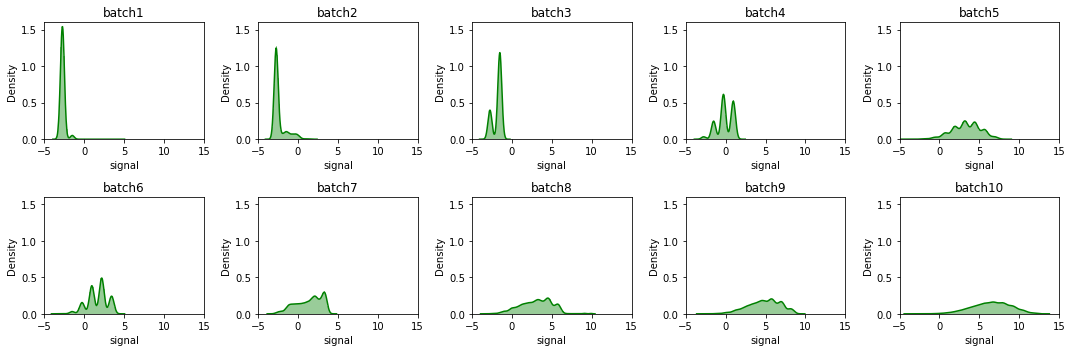

In [6]:
### Plot density ~ signals per batch
warnings.filterwarnings("ignore")
plt.figure(figsize=(15,5))
for i in df['batch'].unique():    
    plt.subplot(2,5,i)
    sns.distplot(df['signal'][df['batch']==i], color='g')  
    plt.xlabel('signal')
    plt.title('batch' + str(i))
    plt.xlim([-5,15])
    plt.ylim([0,1.6])
    plt.tight_layout()  

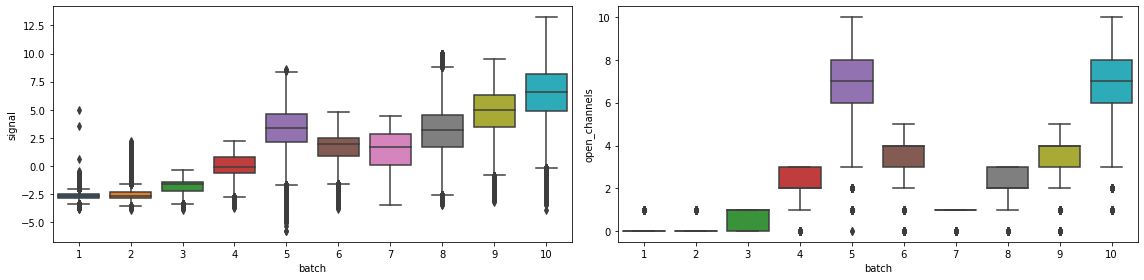

In [5]:
### Plot signal ~ batch and open_channels ~ batch 
plot_list = ['signal','open_channels']
plt.figure(figsize=(16,4))
for i,elem in enumerate(plot_list,1):    
    plt.subplot(1,2,i)
    sns.boxplot(x='batch', y=elem, data=df)
    plt.xlabel('batch')
    plt.ylabel(elem)
    plt.tight_layout() 

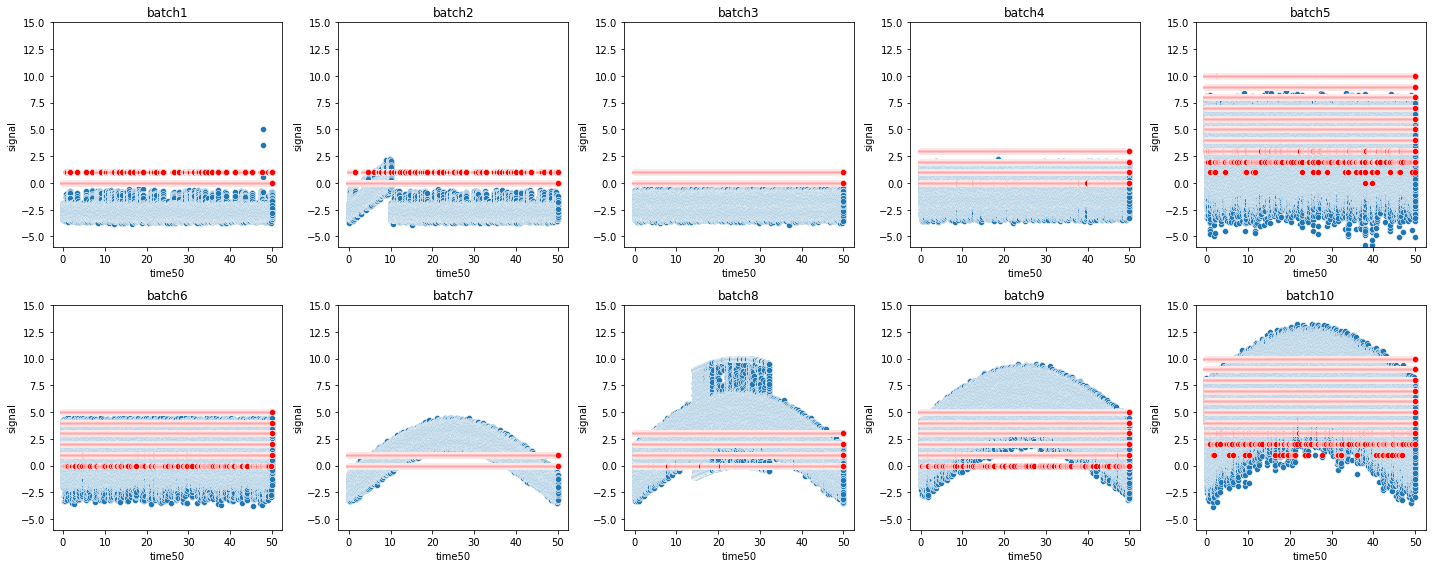

In [23]:
### Plot signal (blue) and open_channels (red) ~ signals per batch
plt.figure(figsize=(20,8))
for i in df['batch'].unique():    
    plt.subplot(2,5,i)
    sns.scatterplot(x='time50', y='signal', data=df[df['batch']==i])   
    sns.scatterplot(x='time50', y='open_channels', data=df[df['batch']==i], color="red")
    plt.title('batch' + str(i))
    plt.ylim([-6,15])
    plt.tight_layout()

#### Create new feature for delta *signal* 
signal_timeDelta: signal(t) - signal(t-1)

In [8]:
df['signal_timeDelta'] = df['signal'].diff()
df['signal_timeDelta'].fillna(method='backfill', inplace=True)
df.head(3)

,signal,open_channels,batch,time50,signal_timeDelta
0,-2.7600,0,1,0.0001,-0.0957
1,-2.8557,0,1,0.0002,-0.0957
2,-2.4074,0,1,0.0003,0.4483


In [10]:
### Eliminate outliers in signal_timeDelta batch-wise
for elem in df["batch"].unique():
    x = df["signal_timeDelta"][df["batch"] == elem]
    q_hi  = x.quantile(0.999)
    q_low = x.quantile(0.001)    
    df["signal_timeDelta"][(df["batch"] == elem) & (df["signal_timeDelta"] > q_hi)] = q_hi
    df["signal_timeDelta"][(df["batch"] == elem) & (df["signal_timeDelta"] < q_low)] = q_low

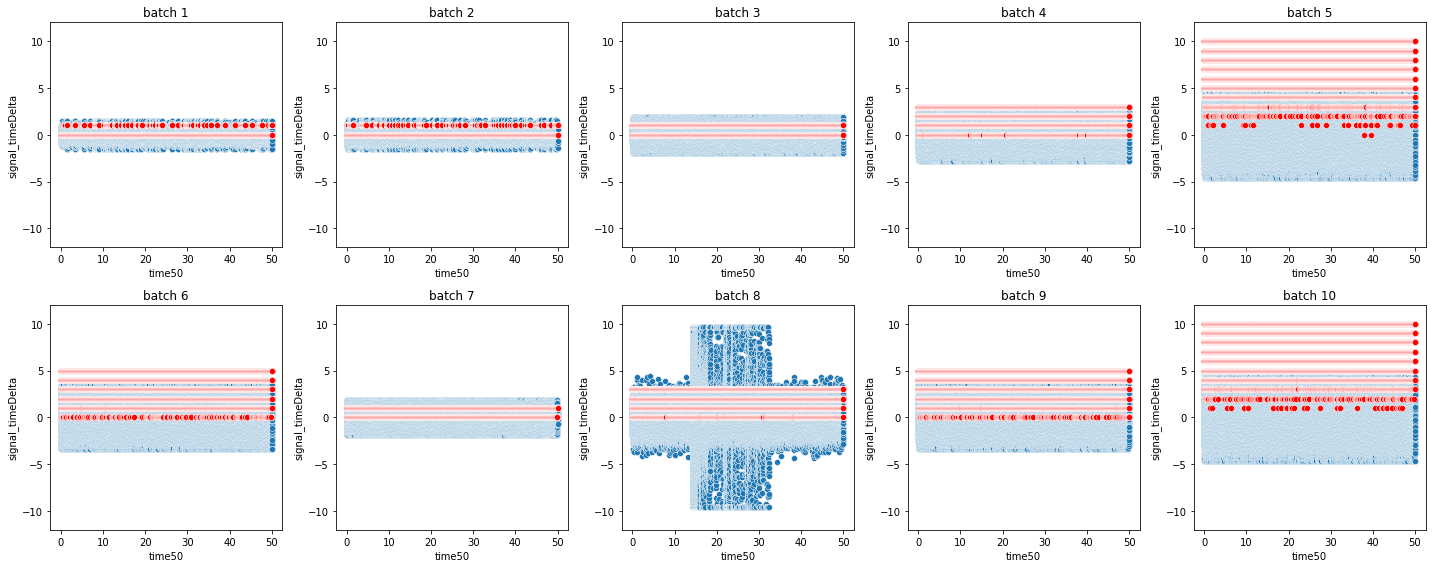

In [24]:
### Plot signal_timeDelta without outliers (blue) and open_channels (red) ~ signals per batch
plt.figure(figsize=(20,8))
for i in df['batch'].unique():     
    plt.subplot(2,5,i)
    sns.scatterplot(x='time50', y='signal_timeDelta', data=df[df['batch']==i])  
    sns.scatterplot(x='time50', y='open_channels', data=df[df['batch']==i], color="red")
    plt.title('batch ' + str(i))
    plt.ylim([-12,12])
    plt.tight_layout() 

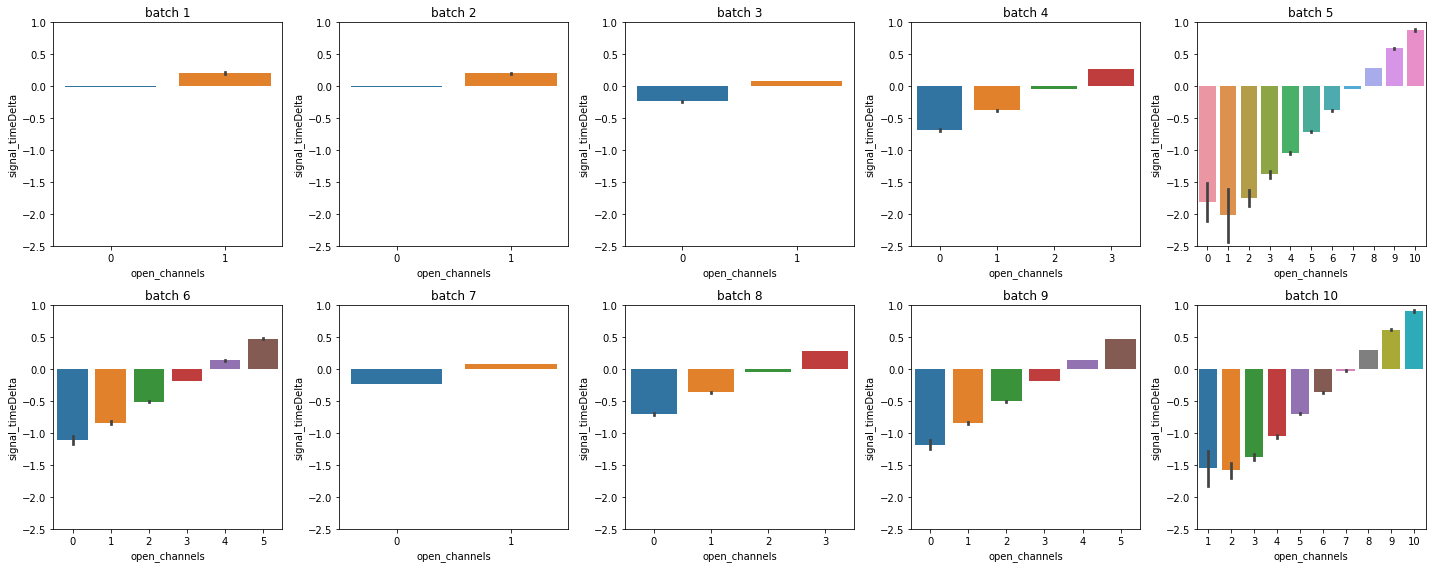

In [13]:
### Plot signal_timeDelta ~ open_channels
plt.figure(figsize=(20,8))
for i in df['batch'].unique():    
    plt.subplot(2,5,i)
    sns.barplot(x='open_channels', y='signal_timeDelta', data=df[df['batch']==i])            
    plt.title('batch ' + str(i))
    plt.ylim([-2.5,1.0])
    plt.tight_layout()

#### Create a new feature for *channel pattern*
Batches 1 and 2, batches 3 and 7, batches 4 and 8 as well as batches 6 and 9 share a similar patterns concerning channels. 

In [14]:
df['channel_pattern'] = 0
channel_pattern_dict = {1:1, 2:1, 3:2, 4:3, 5:4, 6:5, 7:2, 8:3, 9:5, 10:6}
for i in df['batch'].unique():
    for key,value in channel_pattern_dict.items():
        if df['batch'][i] == key:
            df['channel_pattern'][df['batch']==i] = channel_pattern_dict.get(i) 
df.tail()

,signal,open_channels,batch,time50,signal_timeDelta,channel_pattern
4999995,2.9194,7,10,49.9996,-1.4519,6
4999996,2.6980,7,10,49.9997,-0.2214,6
4999997,4.5164,8,10,49.9998,1.8184,6
4999998,5.6397,9,10,49.9999,1.1233,6
4999999,5.3792,9,10,50.0000,-0.2605,6


#### Create new feature *signal width*

In [15]:
df["signal_width"] = 0
for elem in df["batch"].unique():
    max_time = df["signal_timeDelta"][df["batch"] == elem].max()
    min_time = df["signal_timeDelta"][df["batch"] == elem].min()    
    df["signal_width"][df["batch"] == elem] = max_time - min_time    
df.head()

,signal,open_channels,batch,time50,signal_timeDelta,channel_pattern,signal_width
0,-2.7600,0,1,0.0001,-0.0957,1,3.032101
1,-2.8557,0,1,0.0002,-0.0957,1,3.032101
2,-2.4074,0,1,0.0003,0.4483,1,3.032101
3,-3.1404,0,1,0.0004,-0.7330,1,3.032101
4,-3.1525,0,1,0.0005,-0.0121,1,3.032101


#### Plot correlations in a heatmap

<AxesSubplot:>

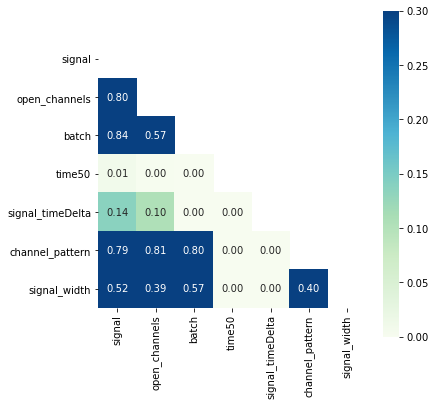

In [19]:
mask = np.triu(np.ones_like(df.corr().abs(), dtype=np.bool))
plt.figure(figsize=(6,6))
sns.heatmap(df.corr().abs(), mask=mask, cmap="GnBu", 
            vmax=.3, square=True, annot=True, fmt='.2f') 

#### Descriptive Statistics

In [20]:
df.describe(include='all')

,signal,open_channels,batch,time50,signal_timeDelta,channel_pattern,signal_width
count,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06
mean,1.386246e+00,2.726043e+00,5.500000e+00,2.500005e+01,5.533620e-06,3.200000e+00,7.095273e+00
std,3.336219e+00,2.665051e+00,2.872282e+00,1.443376e+01,9.146314e-01,1.661325e+00,4.595873e+00
min,-5.796500e+00,0.000000e+00,1.000000e+00,1.000000e-04,-9.554908e+00,1.000000e+00,3.032101e+00
25%,-1.594800e+00,1.000000e+00,3.000000e+00,1.250007e+01,-3.792000e-01,2.000000e+00,3.792101e+00
50%,1.124000e+00,2.000000e+00,5.500000e+00,2.500005e+01,-5.000000e-04,3.000000e+00,6.291303e+00
75%,3.690100e+00,4.000000e+00,8.000000e+00,3.750002e+01,3.781000e-01,5.000000e+00,9.280902e+00
max,1.324400e+01,1.000000e+01,1.000000e+01,5.000000e+01,9.610505e+00,6.000000e+00,1.916541e+01


#### Save DataFrame

In [21]:
df.to_csv('df_preprocessed.csv', index=False)